In [107]:
import sys
import os
from pathlib import Path
# Add the utils directory to sys.path
sys.path.append(str(Path(os.getcwd()).resolve().parents[1]))

import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils.paper_plots import set_custom_color_style

In [108]:
# load data
with open("../../data/feedback_evaluation/evaluation_wide_legs.json") as f:
    data = json.load(f)

In [109]:
import matplotlib.pyplot as plt
from collections import defaultdict

def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct > 5 else ''

def plot_feedback_pies_grid(data, match_type):
    feedback_category = ["positive", "no feedback", "possibly negative", "negative"]
    blues = set_custom_color_style()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    if match_type == "with_self_matches":
        text = "including self matches"
    else:
        text = "excluding self matches"

    gears = ["gear2", "gear3"]
    for idx, gear in enumerate(gears):
        values = defaultdict(int)

        for video_data in data.values():
            # Check for match type
            if match_type not in video_data:
                continue

            gear_data = video_data[match_type].get(gear)
            if not gear_data:
                continue

            all_data = gear_data.get("all")
            if not all_data:
                continue

            for feedback in feedback_category:
                values[feedback] += all_data.get(feedback, 0)

        total = sum(values.values())
        if total == 0:
            axes[idx].text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            axes[idx].set_title(f"{gear.upper()} - {match_type}")
            axes[idx].axis('off')
        else:
            percentages = [100 * values[feedback] / total if total > 0 else 0 for feedback in feedback_category]
            legend_labels = [f"{feedback} - {pct:.1f}%" for feedback, pct in zip(feedback_category, percentages)]
            wedges, _, autotexts = axes[idx].pie(
                [values[s] for s in feedback_category],
                labels=feedback_category,
                #autopct='%1.1f%%',
                autopct= autopct_threshold,
                startangle=90,
                wedgeprops=dict(edgecolor='white'),
                textprops={'color': 'black'},
                pctdistance=0.8,
            )
            for autotext in autotexts:
                autotext.set_color("white")
            axes[idx].legend(wedges, legend_labels, title="Feedback type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
            axes[idx].set_title(f"{gear.upper()} - {text}")
            

    fig.suptitle(f"Feedback Distribution per Gear ({text})", fontsize=14)
    plt.tight_layout()
    plt.show()
    
def plot_push_vs_together_grid(data, match_type):
    feedback_category = ["positive", "no feedback", "possibly negative", "negative"]
    blues = set_custom_color_style()
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # 2 rows, 2 columns

    plot_positions = [
        ("gear2", "push"),
        ("gear3", "push"),
        ("gear2", "together"),
        ("gear3", "together")
    ]
    
    if match_type == "with_self_matches":
        text = "including self matches"
    else:
        text = "excluding self matches"

    for ax, (gear, category) in zip(axes.flat, plot_positions):
        values = defaultdict(int)

        for video_data in data.values():
            if match_type not in video_data:
                continue
            match_data = video_data[match_type]
            if gear not in match_data or category not in match_data[gear]:
                continue
            for feedback in feedback_category:
                values[feedback] += match_data[gear][category].get(feedback, 0)

        total = sum(values.values())
        if total == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.axis('off')
        else:
            percentages = [100 * values[feedback] / total if total > 0 else 0 for feedback in feedback_category]
            legend_labels = [f"{feedback} - {pct:.1f}%" for feedback, pct in zip(feedback_category, percentages)]
            wedges, _, autotexts = ax.pie(
                [values[s] for s in feedback_category],
                labels=feedback_category,
                autopct= autopct_threshold,
                startangle=90,
                wedgeprops=dict(edgecolor='white'),
                textprops={'color': 'black'},
                pctdistance=0.8,
            )
            for autotext in autotexts:
                autotext.set_color("white")
            ax.legend(wedges, legend_labels, title="Feedback type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        ax.set_title(f"{gear.upper()} - {category} ({text})")
    fig.suptitle(f"Push vs Together per Gear ({text})", fontsize=16)
    plt.tight_layout()
    plt.show()

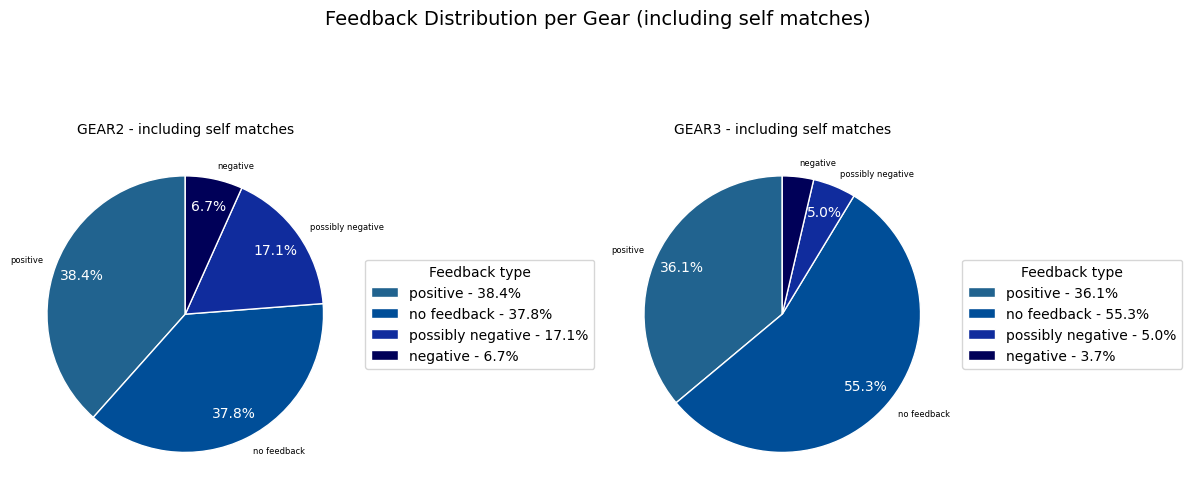

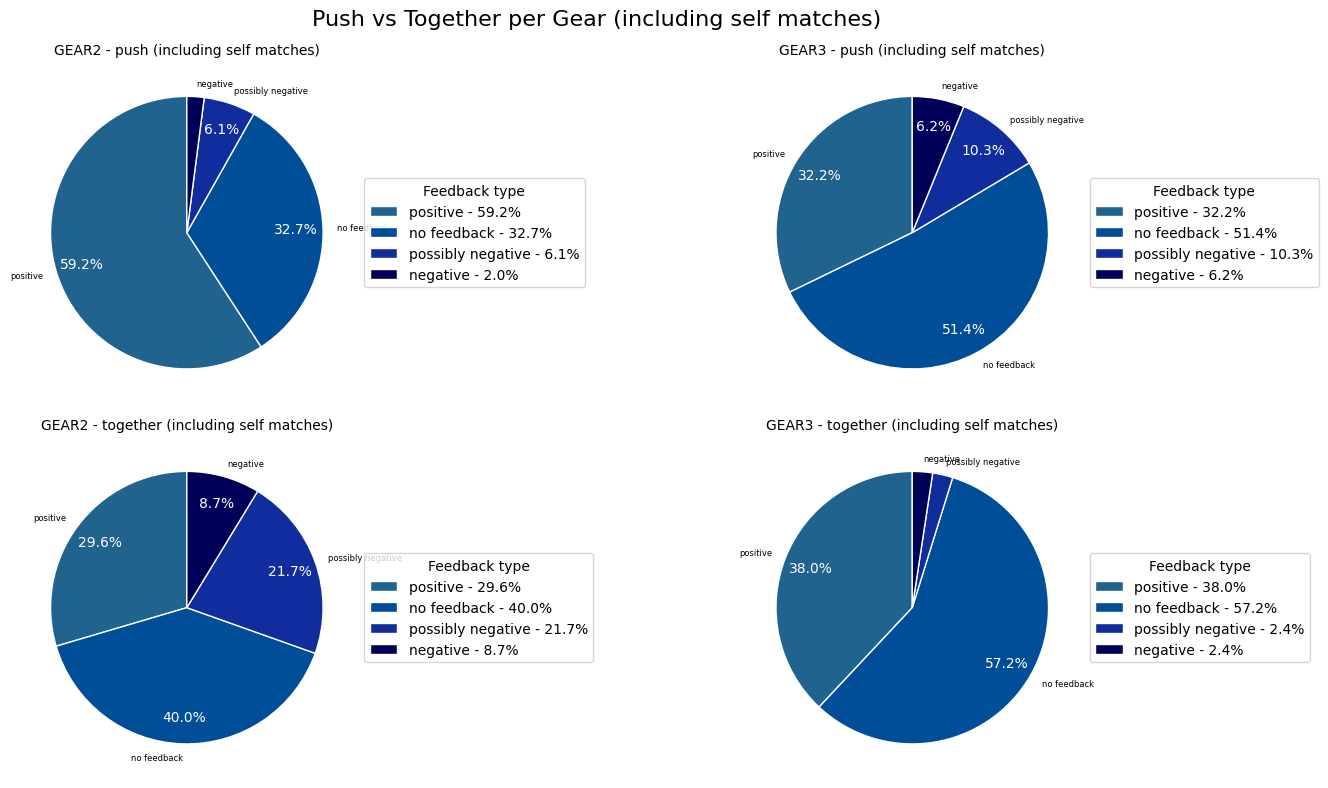

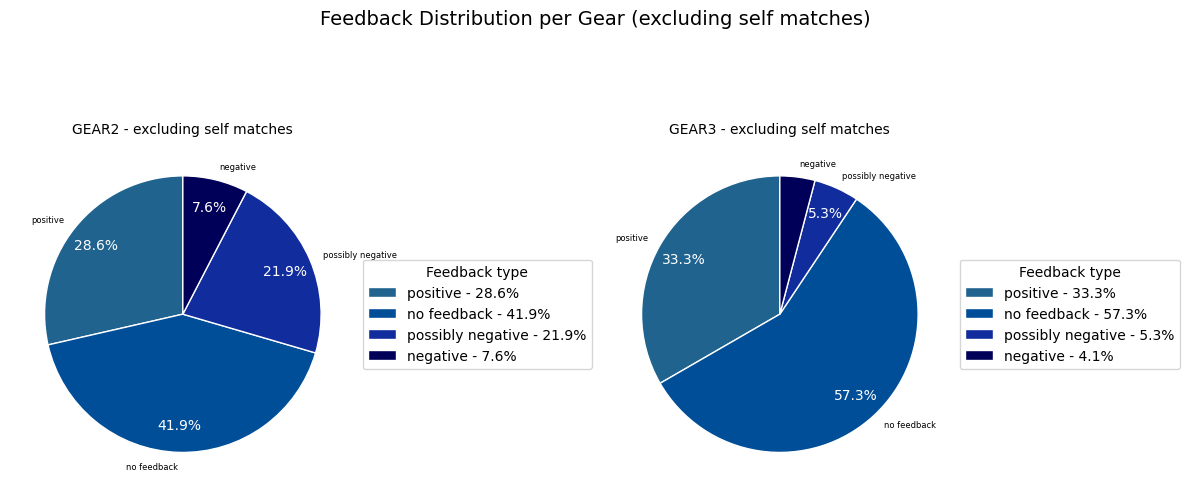

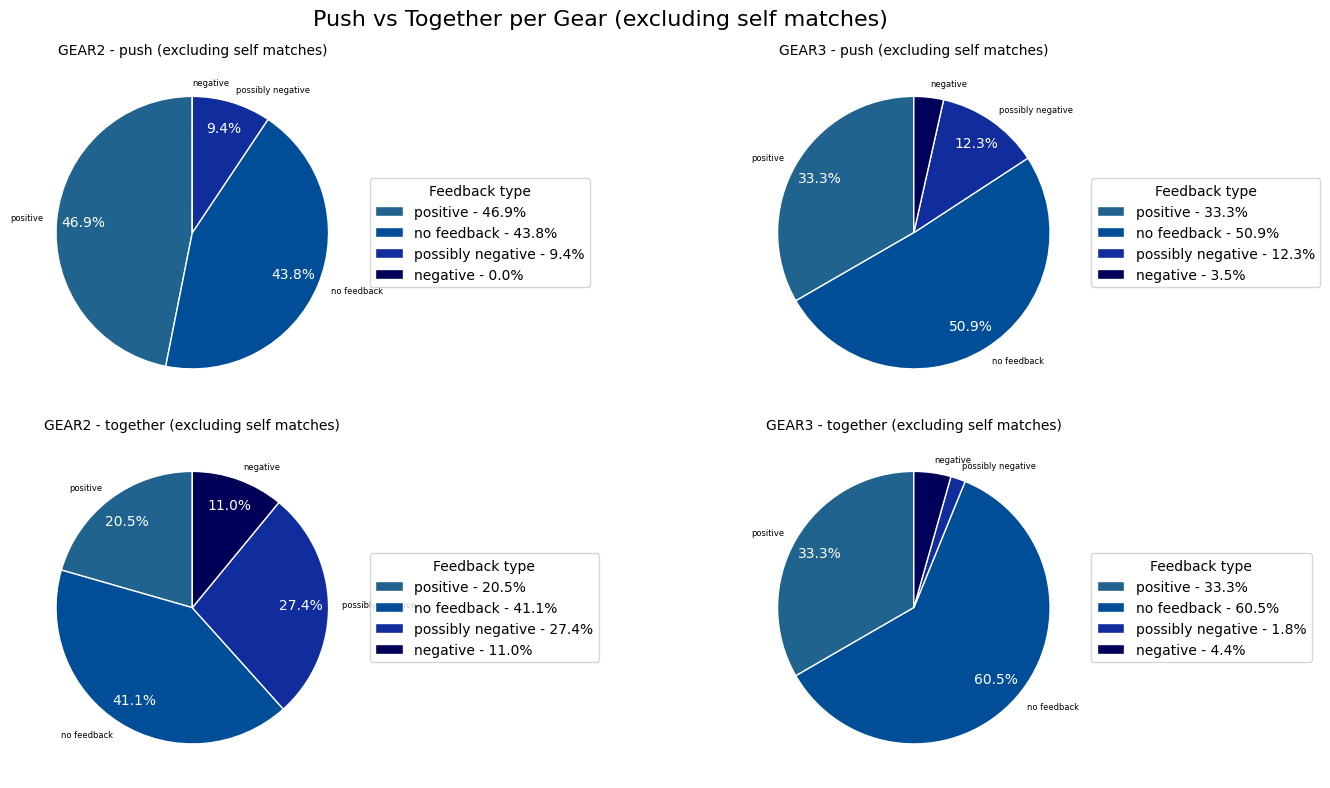

In [110]:
# Generate plots for each match type
for match_type in ["with_self_matches", "no_self_matches"]:
    plot_feedback_pies_grid(data, match_type)
    plot_push_vs_together_grid(data, match_type)

In [102]:
# Scoring weights for each sentiment
sentiment_weights = {
    "positive": 1,
    "no feedback": 0.5,
    "possibly negative": -0.5,
    "negative": -1
}

# Initialize gear scores
gear_scores = {
    "gear2": {},
    "gear3": {}
}

# Iterate over each video and accumulate scores for each gear
for video_id, video_data in data.items():
    for gear in ['gear2', 'gear3']:
        score = 0
        for match_type in ['with_self_matches', 'no_self_matches']:
            if match_type in video_data and gear in video_data[match_type]:
                feedback_category = video_data[match_type][gear].get('all', {})
                for feedback, weight in sentiment_weights.items():
                    count = feedback_category.get(feedback, 0)
                    score += count * weight
        gear_scores[gear][video_id] = score

# Find best and worst videos per gear
for gear in ['gear2', 'gear3']:
    scores = gear_scores[gear]
    best_video = max(scores, key=scores.get)
    worst_video = min(scores, key=scores.get)
    print(f"\n🎯 {gear.upper()}")
    print(f"✅ Best Video: {best_video} (Score: {scores[best_video]})")
    print(f"❌ Worst Video: {worst_video} (Score: {scores[worst_video]})")


🎯 GEAR2
✅ Best Video: 145 (Score: 20.0)
❌ Worst Video: 11 (Score: -2.5)

🎯 GEAR3
✅ Best Video: 158 (Score: 26.0)
❌ Worst Video: 150 (Score: 12.0)
